<a href="https://colab.research.google.com/github/lmoroney/tfbook/blob/master/chapter11/bidi-gru_timeseries-withdropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0-rc2


In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

--2020-04-03 16:41:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘/tmp/station.csv’

/tmp/station.csv    100%[===================>]   6.82K  --.-KB/s    in 0s      

2020-04-03 16:41:34 (55.6 MB/s) - ‘/tmp/station.csv’ saved [6979/6979]



In [0]:
def get_data():
    data_file = "/tmp/station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [0]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

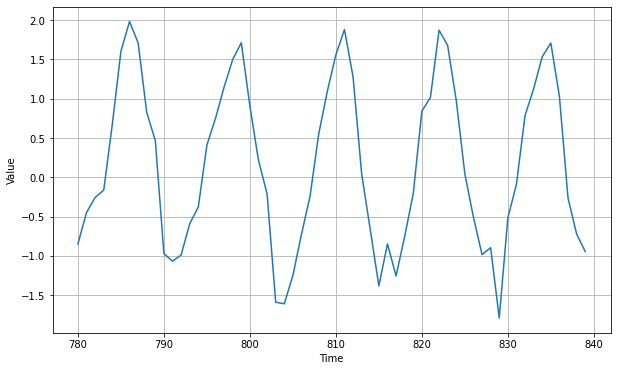

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1),
  tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=1000,  verbose=1, validation_data=valid_dataset)

Epoch 1/1000
38/38 [==============================] - 3s 88ms/step - loss: 0.4599 - mae: 0.8720 - val_loss: 0.5260 - val_mae: 0.9445
Epoch 2/1000
38/38 [==============================] - 3s 78ms/step - loss: 0.4584 - mae: 0.8709 - val_loss: 0.5245 - val_mae: 0.9425
Epoch 3/1000
38/38 [==============================] - 3s 79ms/step - loss: 0.4568 - mae: 0.8687 - val_loss: 0.5230 - val_mae: 0.9404
Epoch 4/1000
38/38 [==============================] - 3s 69ms/step - loss: 0.4552 - mae: 0.8669 - val_loss: 0.5215 - val_mae: 0.9384
Epoch 5/1000
38/38 [==============================] - 3s 66ms/step - loss: 0.4536 - mae: 0.8642 - val_loss: 0.5200 - val_mae: 0.9364
Epoch 6/1000
38/38 [==============================] - 3s 66ms/step - loss: 0.4518 - mae: 0.8625 - val_loss: 0.5185 - val_mae: 0.9344
Epoch 7/1000
38/38 [==============================] - 3s 66ms/step - loss: 0.4504 - mae: 0.8615 - val_loss: 0.5170 - val_mae: 0.9325
Epoch 8/1000
38/38 [==============================] - 3s 66ms/step - 

In [0]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

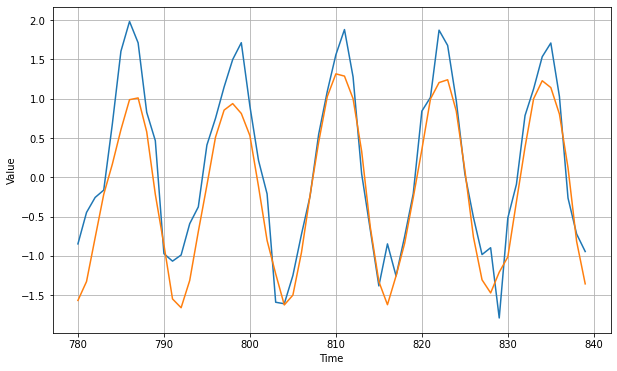

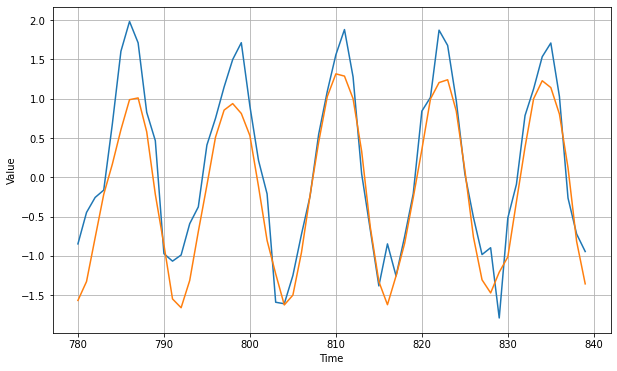

In [12]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid[-100:], x_valid[-100:])
plot_series(time_valid[-100:], forecast[-100:])
plt.show()


In [13]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.37683725


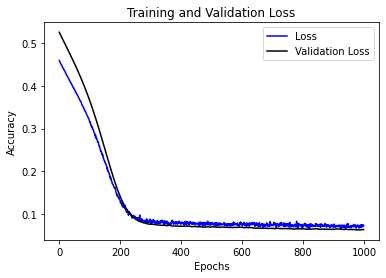

<Figure size 432x288 with 0 Axes>

In [14]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
